In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib
from sklearn import ensemble, metrics, inspection

In [2]:
## If true, load existing model (does not train a new one)
load_existing = True

## If true, save the trained model
save_model = False

## Proton and pion momenta
## 'VF': use VF momenta
## 'DTF': use DTF momenta w/o Lambda m.c.
## 'DTFL': use DTF momenta w/ Lambda m.c.
## 'NO': don't use any momenta for Lambda daughter particles
daughterMomenta = 'VF'

In [3]:
parameters = {
    'random_state': 2021,
    'learning_rate': 0.05,
    'max_depth': 4,
    'max_features': 3,
    'n_estimators': 1000,
    'subsample': 0.7
}

# Load data

In [4]:
inputTrain = '~/classifier-studies/data/trainData.h5'
df_train = pd.read_hdf(inputTrain, 'LHCb_Train')
df_train

,p_PT,p_PZ,DTF_FixJPsi_p_PT,DTF_FixJPsi_p_PZ,DTF_FixJPsiLambda_p_PT,DTF_FixJPsiLambda_p_PZ,pim_PT,pim_PZ,DTF_FixJPsi_pim_PT,DTF_FixJPsi_pim_PZ,...,L_VFASPF_CHI2_VDOF,Lb_VFASPF_CHI2_VDOF,L_BPVIPCHI2,Lb_BPVIPCHI2,L_BPVVDCHI2,Lb_BPVVDCHI2,DTF_FixJPsi_status,DTF_FixJPsiLambda_status,TYPE,DTF_FixJPsiLambda_Lb_M
0,1499.261230,64090.687500,1449.125122,71109.312500,1339.061157,67585.578125,142.576462,16002.674805,222.223770,15295.935547,...,12.397956,1.006837,3.118125,4.247471,8394.141602,839.898499,0.0,0.0,1,5649.782715
1,6531.696777,43770.664062,7950.545410,53713.472656,7250.666016,48946.476562,1098.382568,7154.821289,1173.632935,7339.285645,...,72.018669,4.932845,9.285525,0.700478,316576.343750,28.328979,0.0,0.0,1,5346.287598
2,1195.592285,25513.001953,2846.242432,45061.835938,2590.605225,40850.550781,600.855042,6536.190430,531.966919,6502.588379,...,58.929020,38.498478,109.721619,0.822907,48769.886719,969.064880,0.0,0.0,1,5625.960449
3,8357.870117,48524.460938,13019.551758,77204.125000,10886.081055,65169.863281,954.039429,8363.340820,1251.309082,8721.902344,...,4.634126,2.500692,5.822659,0.760508,2613.000244,11152.960938,0.0,0.0,1,5480.049316
4,931.300659,24994.496094,1355.522217,32809.832031,1152.498901,30213.080078,812.275085,7415.243652,194.003128,7669.465332,...,2.344827,9.562636,28.231209,3.574740,1273.676514,22431.037109,0.0,1.0,1,5446.454102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228493,1220.226567,72937.663691,1427.535278,85209.820312,1239.802612,67344.187500,1089.563873,38845.872752,961.556641,37909.199219,...,0.152025,0.212239,0.582464,8.037920,2371.744690,126.815938,0.0,1.0,0,6832.868652
228494,1083.955904,55949.470793,1105.869141,60395.519531,892.092041,48183.257812,450.382581,27721.281600,485.050476,26523.736328,...,0.300803,1.908871,0.620846,1.462356,74049.033084,19.377282,0.0,1.0,0,6612.175781
228495,567.501520,37682.446927,5925.211914,436724.312500,1658.590454,121800.218750,398.880250,12929.648726,275.511749,10452.941406,...,257.919474,67.560202,197.839502,175.666290,368006.797335,212.409329,0.0,1.0,0,8911.302734
228496,758.780272,33543.168911,941.613098,42739.785156,7304.916016,323111.187500,705.825113,29903.281153,768.507690,34001.078125,...,0.161039,2.624455,7.957362,99.010018,4205.262286,418.366858,0.0,1.0,0,9774.763672


In [5]:
inputTest = '~/classifier-studies/data/testData.h5'
df_test = pd.read_hdf(inputTest, 'LHCb_Test')
df_test

,p_PT,p_PZ,DTF_FixJPsi_p_PT,DTF_FixJPsi_p_PZ,DTF_FixJPsiLambda_p_PT,DTF_FixJPsiLambda_p_PZ,pim_PT,pim_PZ,DTF_FixJPsi_pim_PT,DTF_FixJPsi_pim_PZ,...,L_VFASPF_CHI2_VDOF,Lb_VFASPF_CHI2_VDOF,L_BPVIPCHI2,Lb_BPVIPCHI2,L_BPVVDCHI2,Lb_BPVVDCHI2,DTF_FixJPsi_status,DTF_FixJPsiLambda_status,TYPE,DTF_FixJPsiLambda_Lb_M
0,2504.376465,27455.556641,2435.769775,27417.642578,2798.346191,31182.896484,416.471710,5826.424316,492.247925,5925.514648,...,0.116805,0.334404,0.975463,2.368801,8.063968e+03,1031.350098,0.0,0.0,1,5678.738770
1,3678.204834,28957.984375,8009.698242,63035.414062,4010.383301,31700.259766,511.451996,4495.157227,606.036377,5295.169922,...,129.013321,2.213622,3.035450,4.987368,1.139099e+06,132.812775,0.0,0.0,1,5152.405273
2,6151.153320,62528.351562,3390.550049,34433.933594,3191.249023,32347.107422,908.855103,8341.050781,954.033325,8586.155273,...,3.052457,1.626008,3.995702,3.794894,5.994128e+05,1733.996338,0.0,0.0,1,5610.329102
3,2215.048828,16164.611328,3509.922363,25586.275391,3299.109375,24183.917969,1217.576172,8981.918945,1129.961060,8099.306641,...,3.684547,6.168911,7.633062,1.222096,6.435177e+03,1848.107422,0.0,0.0,1,5655.911133
4,1299.116333,50831.921875,1585.503662,49852.496094,1661.818237,48686.039062,1164.087158,16436.048828,707.395447,15532.739258,...,3.191066,0.135195,0.518211,1.912595,1.069037e+03,329.424927,0.0,1.0,1,5623.918457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25385,645.364567,14948.375359,658.586609,15131.017578,12712.377930,261919.109375,757.699363,17478.384328,759.258667,17625.787109,...,1.038850,0.812649,0.076899,11.266728,1.439183e+03,61.443946,0.0,3.0,0,10345.851562
25386,592.379896,28444.692313,920.779602,47065.058594,1599.084717,115516.109375,315.389950,22296.099434,180.996719,18559.517578,...,0.067244,21.352331,56.091567,94.749679,2.668843e+05,448.338019,0.0,3.0,0,11415.735352
25387,636.473898,27506.147195,505.863983,20288.097656,7521.579102,311244.218750,799.192766,31655.233084,711.814575,28853.048828,...,2.411407,2.617817,1.098988,24.841964,1.060404e+04,59949.689634,0.0,3.0,0,18485.015625
25388,681.055386,28981.688872,581.269653,24546.640625,986.649902,44888.769531,643.814391,28848.166781,1090.433594,46704.347656,...,0.841319,14.690842,32.489640,125.641237,1.039346e+06,1235.642132,0.0,1.0,0,8497.440430


# Train the classifier

In [6]:
if daughterMomenta == 'VF':
    pMomenta = ['p_PT', 'p_PZ']
    pimMomenta = ['pim_PT', 'pim_PZ']
elif daughterMomenta == 'DTF':
    pMomenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pimMomenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughterMomenta == 'DTFL':
    pMomenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pimMomenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughterMomenta == 'NO':
    pMomenta = []
    pimMomenta = []
else:
    raise ValueError(daughterMomenta + " is not a valid option for momenta usage.")

In [7]:
fixedFeatures = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

In [8]:
features = pMomenta + pimMomenta + fixedFeatures

In [9]:
X_train = df_train.loc[:, features].to_numpy()
Y_train = df_train.loc[:, 'TYPE'].to_numpy()

X_test = df_test.loc[:, features].to_numpy()
Y_test = df_test.loc[:, 'TYPE'].to_numpy()

In [10]:
savedStateDirectory = './saved_states'

stateFileName = (
    'BDT_'
    + daughterMomenta
    + '_' + str(parameters['learning_rate'])
    + '_' + str(parameters['max_depth'])
    + '_' + str(parameters['max_features'])
    + '_' + str(parameters['n_estimators'])
    + '_' + str(parameters['subsample'])
)

savedStateFullPath = savedStateDirectory + '/' + stateFileName + '.joblib'
savedStateFullPath

'./saved_states/BDT_VF_0.05_4_3_1000_0.7.joblib'

In [11]:
if load_existing:
    tickBDTImport = time.perf_counter()
    BDT = joblib.load(savedStateFullPath)
    tockBDTImport = time.perf_counter()
    print(f"BDT imported in {(tockBDTImport - tickBDTImport):0.4f} seconds.")
else:
    BDT = ensemble.GradientBoostingClassifier(**parameters)
    
    tickBDT = time.perf_counter()
    BDT.fit(X_train, Y_train)
    tockBDT = time.perf_counter()
    print(f"BDT trained in {(tockBDT - tickBDT)/60:0.4f} minutes.")
    
    if save_model:
        tickSave = time.perf_counter()
        joblib.dump(BDT, savedStateFullPath)
        tockSave = time.perf_counter()
        print(f"BDT saved in {(tockSave - tickSave):0.4f} seconds.")

BDT imported in 0.0364 seconds.


# BDT results
## Predict the events

In [12]:
Y_train_predicted = BDT.predict(X_train)
Y_test_predicted = BDT.predict(X_test)

## predict_proba returns a NumberOfEvents * NumberOfClasses matrix
## The way we have defined it, the second column is the probability of class 1 (i.e. signal)
## Therefore we get that one
Y_train_proba_predicted = BDT.predict_proba(X_train)[:,1]
Y_test_proba_predicted = BDT.predict_proba(X_test)[:,1]

## Confusion matrices

In [13]:
confusionMatrix_Train = metrics.confusion_matrix(Y_train,Y_train_predicted)
confusionMatrix_Train = confusionMatrix_Train/np.sum(confusionMatrix_Train)

confusionMatrix_Test = metrics.confusion_matrix(Y_test,Y_test_predicted)
confusionMatrix_Test = confusionMatrix_Test/np.sum(confusionMatrix_Test)

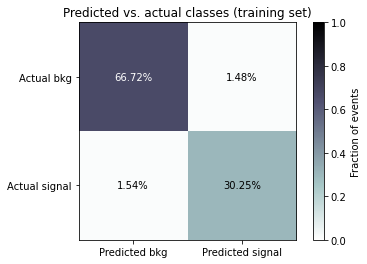

In [14]:
plt.imshow(confusionMatrix_Train, cmap='bone_r')
ax = plt.gca()
plt.colorbar(label='Fraction of events')
plt.clim(0,1)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted bkg', 'Predicted signal'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual bkg', 'Actual signal'))
plt.text(0, 1, "{:.2%}".format(confusionMatrix_Train[1, 0]), ha='center', va='center', color='k')
plt.text(0, 0, "{:.2%}".format(confusionMatrix_Train[0, 0]), ha='center', va='center', color='w')
plt.text(1, 0, "{:.2%}".format(confusionMatrix_Train[0, 1]), ha='center', va='center', color='k')
plt.text(1, 1, "{:.2%}".format(confusionMatrix_Train[1, 1]), ha='center', va='center', color='k')
plt.title("Predicted vs. actual classes (training set)")
plt.show()

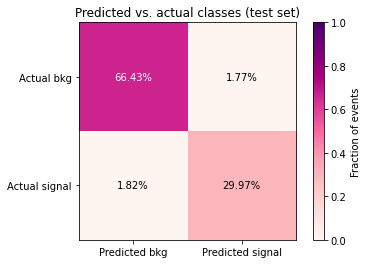

In [15]:
plt.imshow(confusionMatrix_Test, cmap='RdPu')
ax = plt.gca()
plt.colorbar(label='Fraction of events')
plt.clim(0,1)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted bkg', 'Predicted signal'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual bkg', 'Actual signal'))
plt.text(0, 1, "{:.2%}".format(confusionMatrix_Test[1, 0]), ha='center', va='center', color='k')
plt.text(0, 0, "{:.2%}".format(confusionMatrix_Test[0, 0]), ha='center', va='center', color='w')
plt.text(1, 0, "{:.2%}".format(confusionMatrix_Test[0, 1]), ha='center', va='center', color='k')
plt.text(1, 1, "{:.2%}".format(confusionMatrix_Test[1, 1]), ha='center', va='center', color='k')
plt.title("Predicted vs. actual classes (test set)")
plt.show()

## Classification reports

In [16]:
print("TRAIN")
print(metrics.classification_report(Y_train, Y_train_predicted))
print(f'The average precision score on training data is: {metrics.average_precision_score(Y_train, Y_train_proba_predicted):.4f}')
print("------------------------------------------------------")
print("TEST")
print(metrics.classification_report(Y_test, Y_test_predicted))
print(f'The average precision score on test data is: {metrics.average_precision_score(Y_test, Y_test_proba_predicted):.4f}')

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    155849
           1       0.95      0.95      0.95     72649

    accuracy                           0.97    228498
   macro avg       0.97      0.96      0.97    228498
weighted avg       0.97      0.97      0.97    228498

The average precision score on training data is: 0.9901
------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17317
           1       0.94      0.94      0.94      8073

    accuracy                           0.96     25390
   macro avg       0.96      0.96      0.96     25390
weighted avg       0.96      0.96      0.96     25390

The average precision score on test data is: 0.9846


## ROC curve

In [17]:
falsePositiveRates_Train, truePositiveRates_Train, thresholds_Trrain = metrics.roc_curve(Y_train, Y_train_proba_predicted)
areaUnderCurve_Train = metrics.roc_auc_score(Y_train, Y_train_proba_predicted)

falsePositiveRates_Test, truePositiveRates_Test, thresholds_Test = metrics.roc_curve(Y_test, Y_test_proba_predicted)
areaUnderCurve_Test = metrics.roc_auc_score(Y_test, Y_test_proba_predicted)

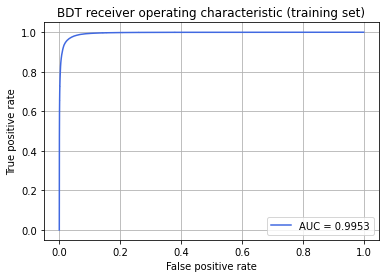

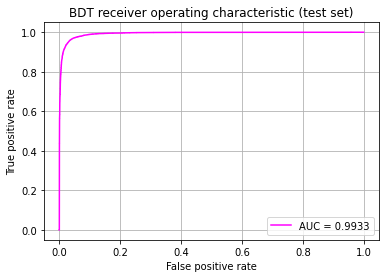

In [18]:
plt.plot(falsePositiveRates_Train, truePositiveRates_Train,
         label=f'AUC = {areaUnderCurve_Train:.4f}',
         color='royalblue')
plt.grid()
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("BDT receiver operating characteristic (training set)")
plt.show()

plt.plot(falsePositiveRates_Test, truePositiveRates_Test, label=f'AUC = {areaUnderCurve_Test:.4f}', color='fuchsia')
plt.grid()
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("BDT receiver operating characteristic (test set)")
plt.show()

## Precision-recall curve

In [19]:
precisions_Train, recalls_Train, PRC_Thresholds_Train = metrics.precision_recall_curve(Y_train, Y_train_proba_predicted)
precisions_Test, recalls_Test, PRC_Thresholds_Test = metrics.precision_recall_curve(Y_test, Y_test_proba_predicted)

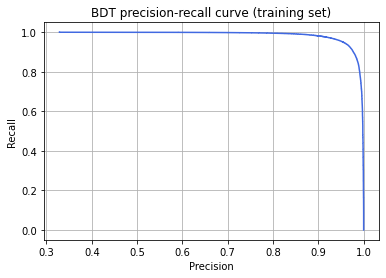

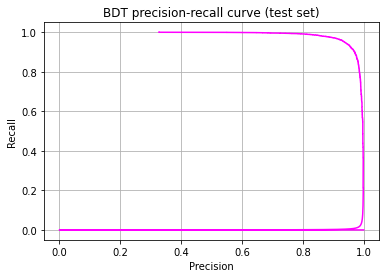

In [20]:
plt.plot(precisions_Train, recalls_Train, color='royalblue')
plt.grid()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title("BDT precision-recall curve (training set)")
plt.show()

plt.plot(precisions_Test, recalls_Test, color='fuchsia')
plt.grid()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title("BDT precision-recall curve (test set)")
plt.show()